In [113]:
import os
import numpy as np
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib.cm import *
from scipy.signal import convolve2d as conv2, convolve
from tqdm import tqdm
import pandas as pd

from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool

from PIL import Image



plt.rcParams['figure.figsize'] = (20, 8)

In [114]:
AVAILABLE_CPU = multiprocessing.cpu_count()

In [115]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('X.npy')
        Y = np.load('Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    
    X_unf = np.copy(X)    
    X = np.array([X[i].flatten() for i in range(len(X))])
    Y = np.where(Y==1)[1]
    permutation = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
    for i in range(len(Y)):
        Y[i] = permutation[Y[i]]
        
    return X, X_unf, Y


if __name__ == '__main__':
    X, X_unf, Y = get_dataset()

In [116]:
# cleaning
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]
def cleaning(img, rows):
    for row in rows:
        img[row][0:10] = 1
        img[row][53:64] = 1
    return img

In [117]:
def clean_image(image, threshold = 0.5, new_size_tuple = (64,64)):
    new_img = []
    for el in image.flat: 
        if el > threshold: new_img.append(1)
        else: new_img.append(0)
        
    return np.array(new_img)

In [39]:
img = X[0]
    
new_img = clean_image(img)

8


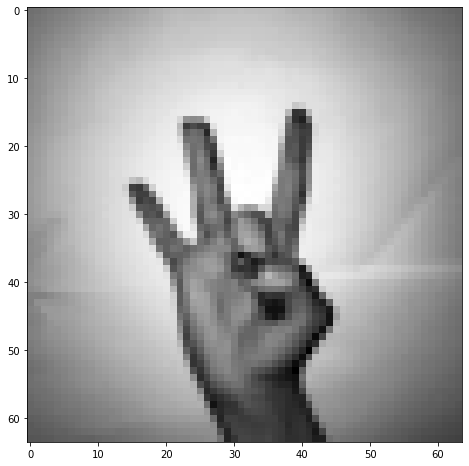

In [40]:
idx = 1200
print(Y[idx])
plt.imshow(X[idx].reshape(64, 64), cmap='gray', interpolation='nearest')

# Principal Component Analysis

## Normalization

### pseudo normalization

In [121]:
def compute_ground_matrix_couple(index, y_i, X):
    '''
    This takes as input the index of a groundtruth and the groundtruth itself aswell as the dataset.
    First it finds the image in position [y_i], 
    it then computes its cleaned matrix and returns it as a key value pair.
    '''
    
    ground_truth = str(np.where(y_i == 1)[0][0])
    image = clean_image(X[index])
    print(f"image {image}")
    return (ground_truth, image)


def matrix_addition(A, B) :
    return [[A[i][j] + B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]

def matrix_subtraction(A, B) :
    return [[A[i][j] - B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]


def extract_Y_indexes_with_label(Y,label) :
    hot_vec = np.zeros(10)
    hot_vec[label] = 1
    indexes = []
    for idx, el in enumerate(Y) :
        if ((el == hot_vec).all()) :
            indexes.append(idx)
    return indexes

def compute_likelihood_mt(Y, X):
    '''
    This works similar to a map reduce approach:
    it finds every image for every ground truth and then zips them into a singular one which becomes of probabilities.
    '''
    lhoods = {}
    for i in range(10) :
        lhoods[i] = (np.mean(X[extract_Y_indexes_with_label(Y,i)], axis=0))

    return lhoods

def compute_mean_image(X):
    print(X.shape)
    print(len(X[:]))
    return np.mean(X, axis=0)

In [119]:
image_residual = compute_mean_image(X_unf)

(2062, 64, 64)
2062


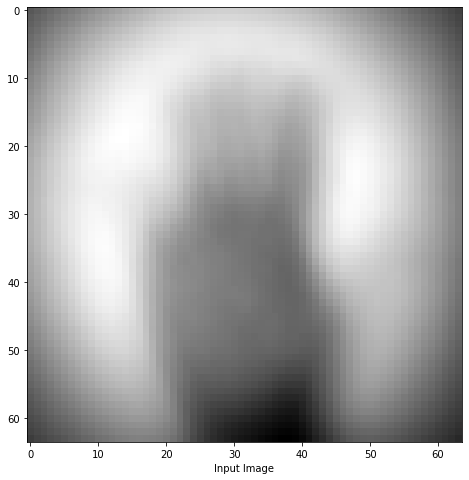

In [120]:
image_0 = image_residual
#print(smooth_img.shape)
plt.figure(1)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('Input Image')
plt.sca(ax1)
plt.imshow(image_0, cmap='gray')
plt.show()

In [127]:
X_without_mean = [x - image_residual for x in X_unf]

In [98]:
def standardize_image(X) :
    for idx, x in enumerate(X) :
        mean = np.mean(x)
        std = np.std(x)
        X[idx] = (x - mean) / std

In [99]:
print(X.shape)
standardize_image(X_unf)

(2062, 4096)


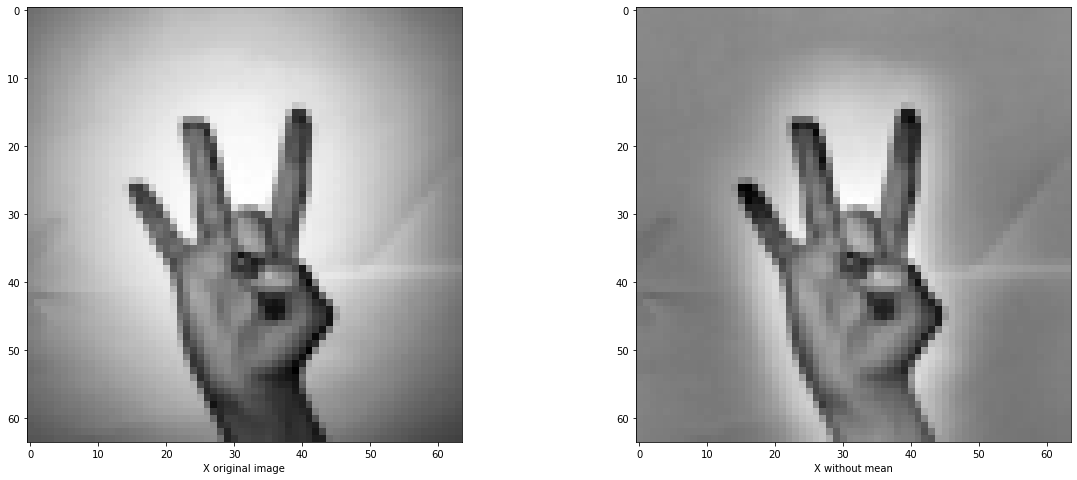

In [128]:
plt.figure(2)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('X original image')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('X without mean')
plt.sca(ax1)
plt.imshow(X_unf[1200], cmap='gray', interpolation='nearest')
plt.sca(ax2)
plt.imshow(X_without_mean[1200], cmap='gray', interpolation='nearest')
plt.show()

In [135]:
X_no_mean_flattened = [x.flatten() for x in X_without_mean]

In [138]:
print(X_no_mean_flattened[0].shape)

(4096,)


In [146]:
ncomp = 64

pca2 = PCA(n_components=ncomp)  # For example 2-PC
principalComponents = pca2.fit_transform(X_no_mean_flattened[:])
    

In [152]:
principalComponents.shape

(2062, 64)

In [139]:
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
varianze=np.cumsum(explained_variance_ratio)

print(varianze)

[0.15550347 0.2472528  0.3030218  0.35662774 0.40564257 0.44930393
 0.48493223 0.51279069 0.53885804 0.56317506 0.58623727 0.60893687
 0.6291678  0.64762183 0.66564843 0.68279934 0.69908394 0.71447071
 0.72917694 0.74253849 0.75477022 0.76666618 0.77805763 0.78895533
 0.79903342 0.80832606 0.81722193 0.82574794 0.83384018 0.84145472
 0.84878807 0.85587436 0.86270143 0.86935634 0.87576998 0.88177643
 0.88776595 0.89344427 0.89908945 0.90450806 0.90985352 0.91484657
 0.91975851 0.92460445 0.92935738 0.9339426  0.9384396  0.94283285
 0.94702185 0.9511041  0.95511195 0.95905525 0.96294832 0.96669177
 0.97037113 0.97399534 0.97749763 0.98096744 0.98436213 0.98761136
 0.99082728 0.99392264 0.99698891 1.        ]


In [143]:
print(len(varianze[varianze <= 0.85] ))
print(len(varianze[varianze <= 0.95] ))

31
49


# NAIVE BAYES

In [144]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut

import naive_bayes_custom

## Gaussian NB

In [172]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [173]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [174]:
score.mean()

0.6265636669156086

In [175]:
mat = confusion_matrix(Ytest, Ymodel)

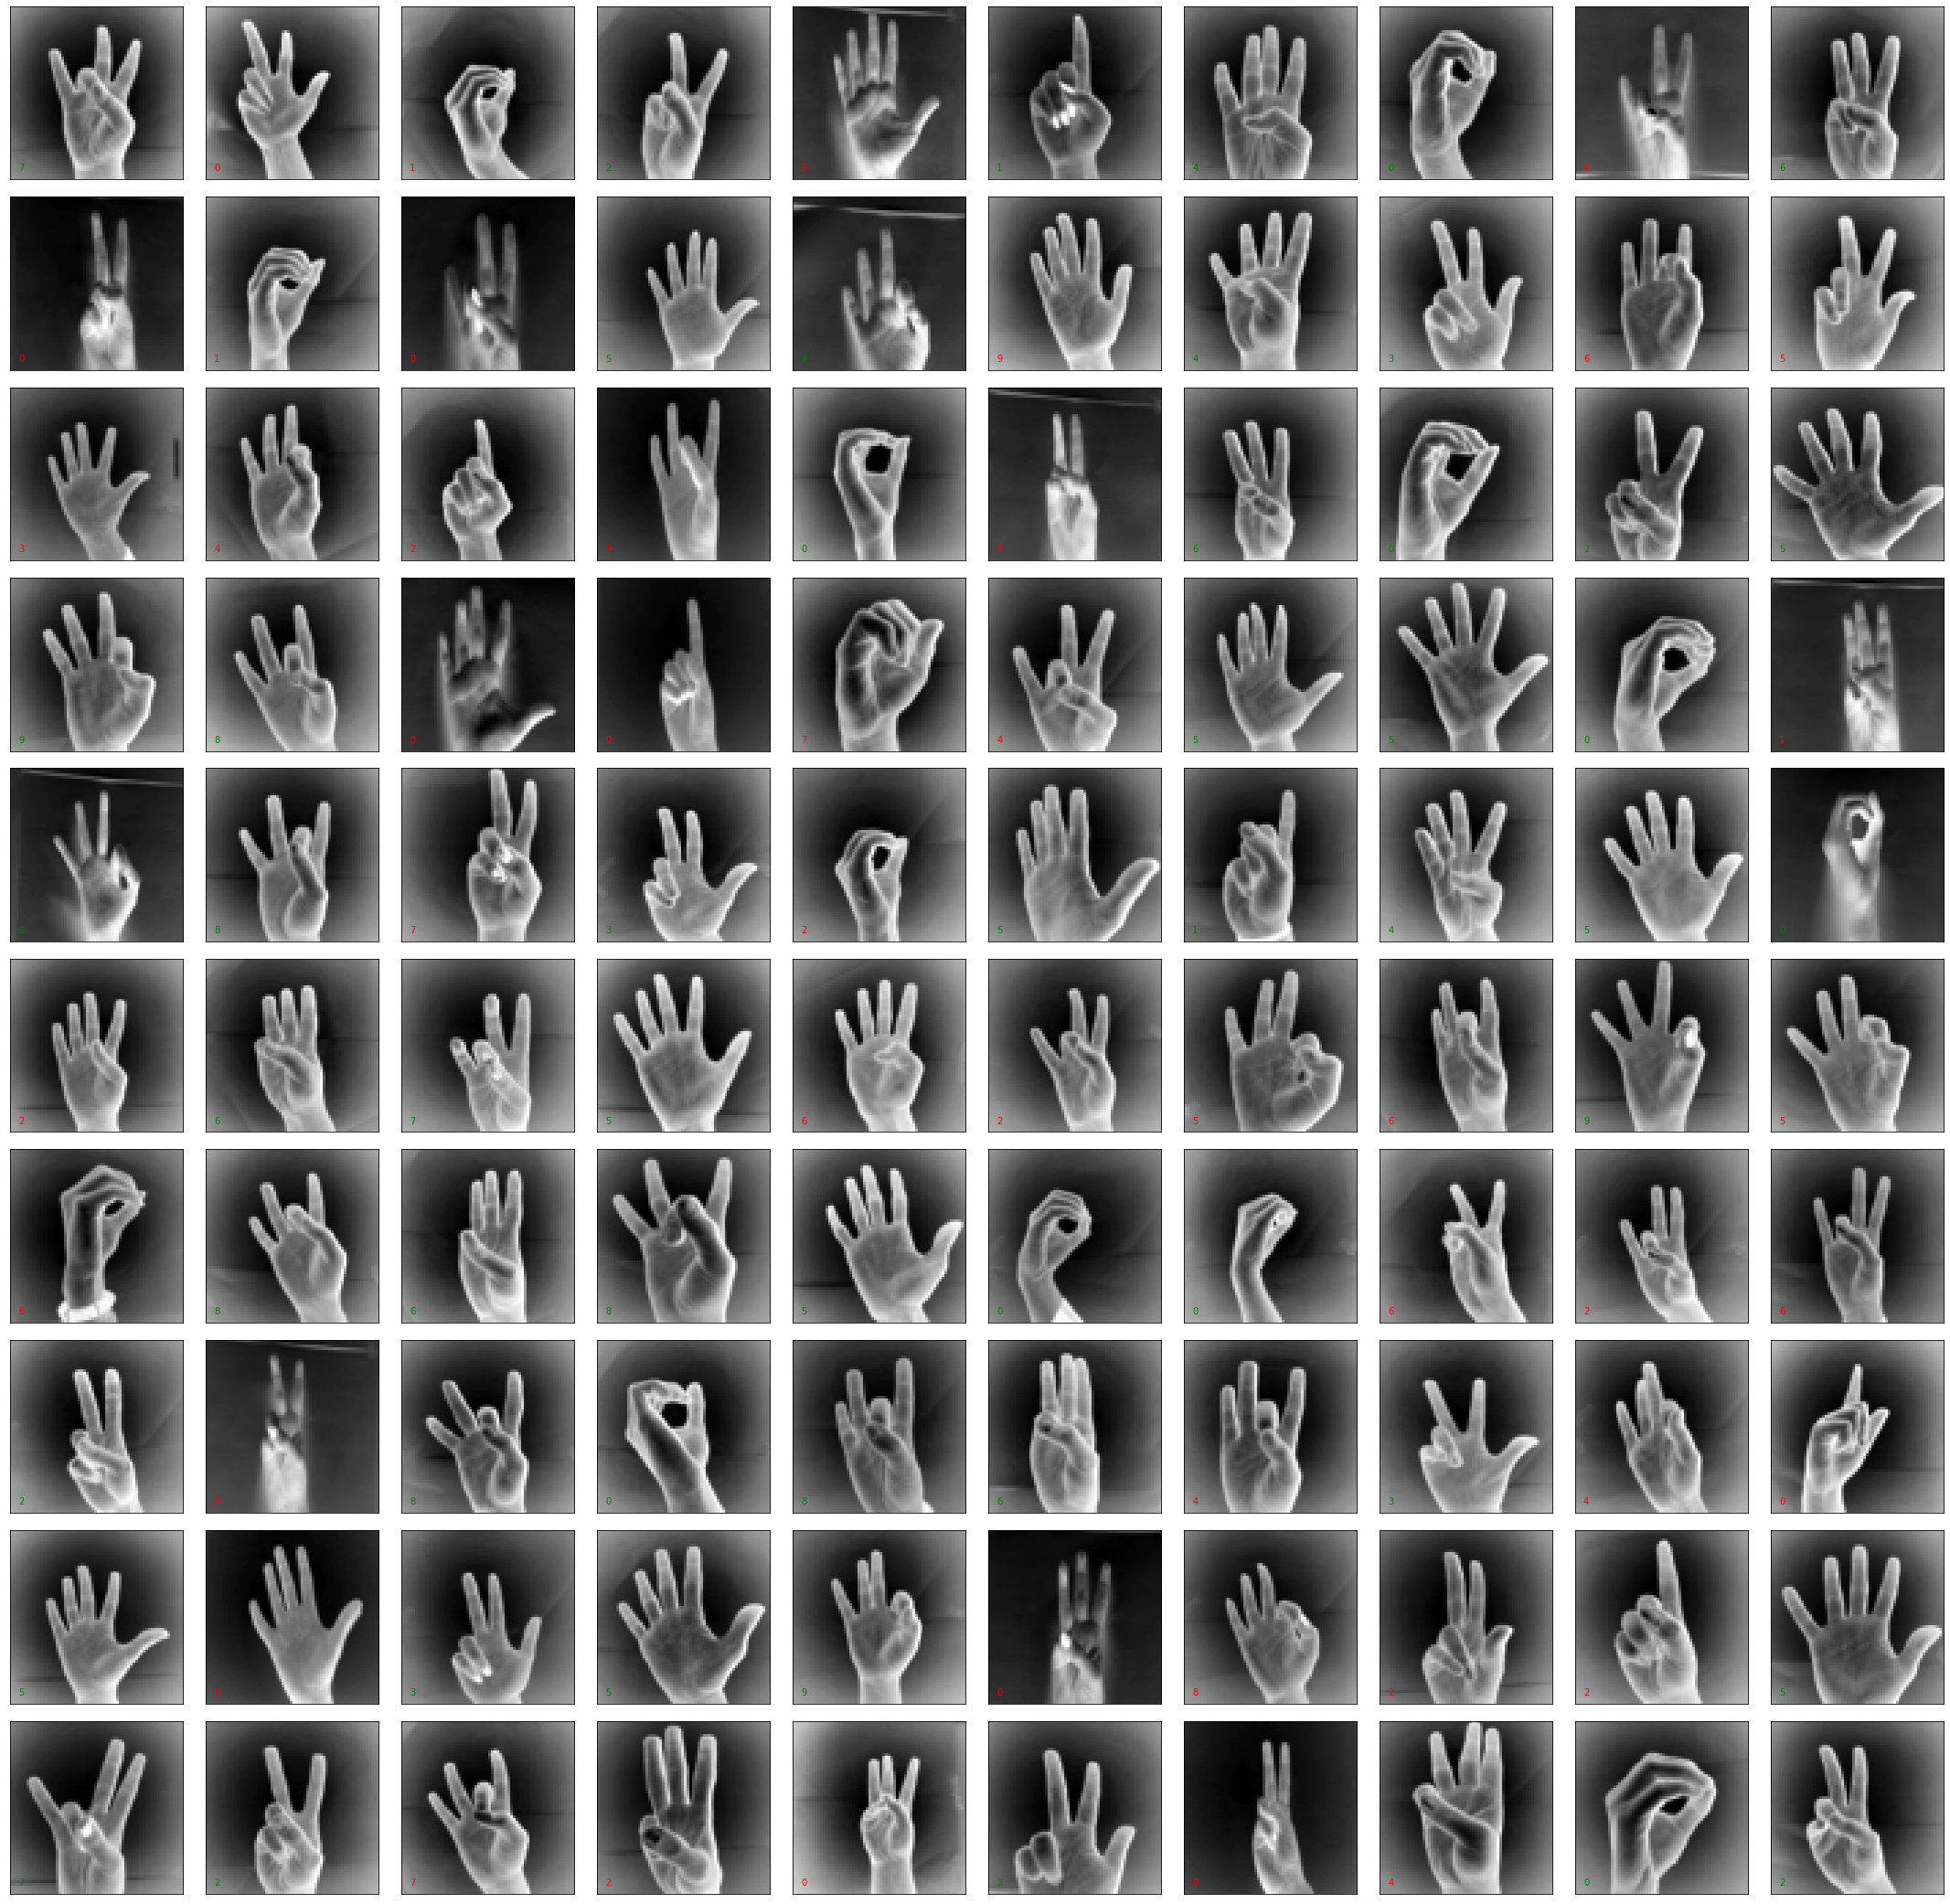

In [177]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## GAUSSIAN NB with PCA

In [147]:
# working with normal images
XtrainPCA, XtestPCA, Ytrain, Ytest = train_test_split(principalComponents,Y)

In [148]:
model = GaussianNB()
model.fit(XtrainPCA, Ytrain)
score = cross_val_score(model, principalComponents, Y, cv=20)
Ymodel = model.predict(XtestPCA)

In [161]:
components_chances = [35, 40, 45, 50, 55, 57, 58, 59, 60]
results = []

for comp_amount in components_chances:
    PCA_matrix = principalComponents[:, :comp_amount]

    #PCA_matrix = np.array([PCA_matrix[i].flatten() for i in range(len(PCA_matrix))])
    X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
    model = GaussianNB()
    model.fit(X_train, Y_train)
    score = cross_val_score(model, PCA_matrix, Y, cv=LeaveOneOut(), n_jobs = AVAILABLE_CPU)
    Ymodel = model.predict(X_test)
    results.append(score.mean())
    

In [162]:
for i in range(len(results)):
    print(f"avg score obtained with {components_chances[i]} components : {results[i]}")

avg score obtained with 35 components : 0.7245392822502424
avg score obtained with 40 components : 0.7318137730358875
avg score obtained with 45 components : 0.7386032977691561
avg score obtained with 50 components : 0.7386032977691561
avg score obtained with 55 components : 0.7390882638215325
avg score obtained with 57 components : 0.7400581959262852
avg score obtained with 58 components : 0.7395732298739088
avg score obtained with 59 components : 0.7424830261881669
avg score obtained with 60 components : 0.7400581959262852


In [209]:
score.mean()

0.39815712900096994

In [210]:
mat = confusion_matrix(Ytest, Ymodel)

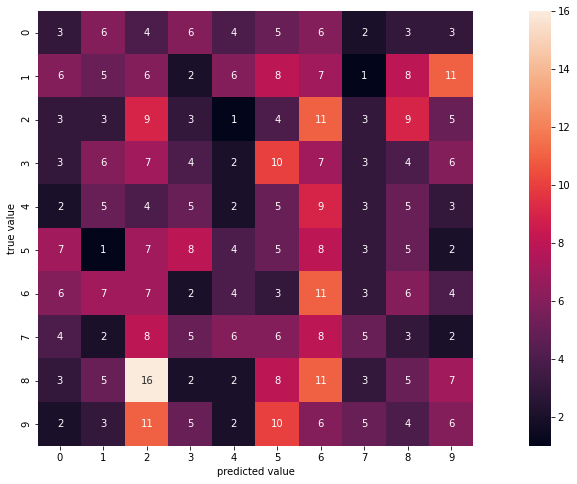

In [211]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

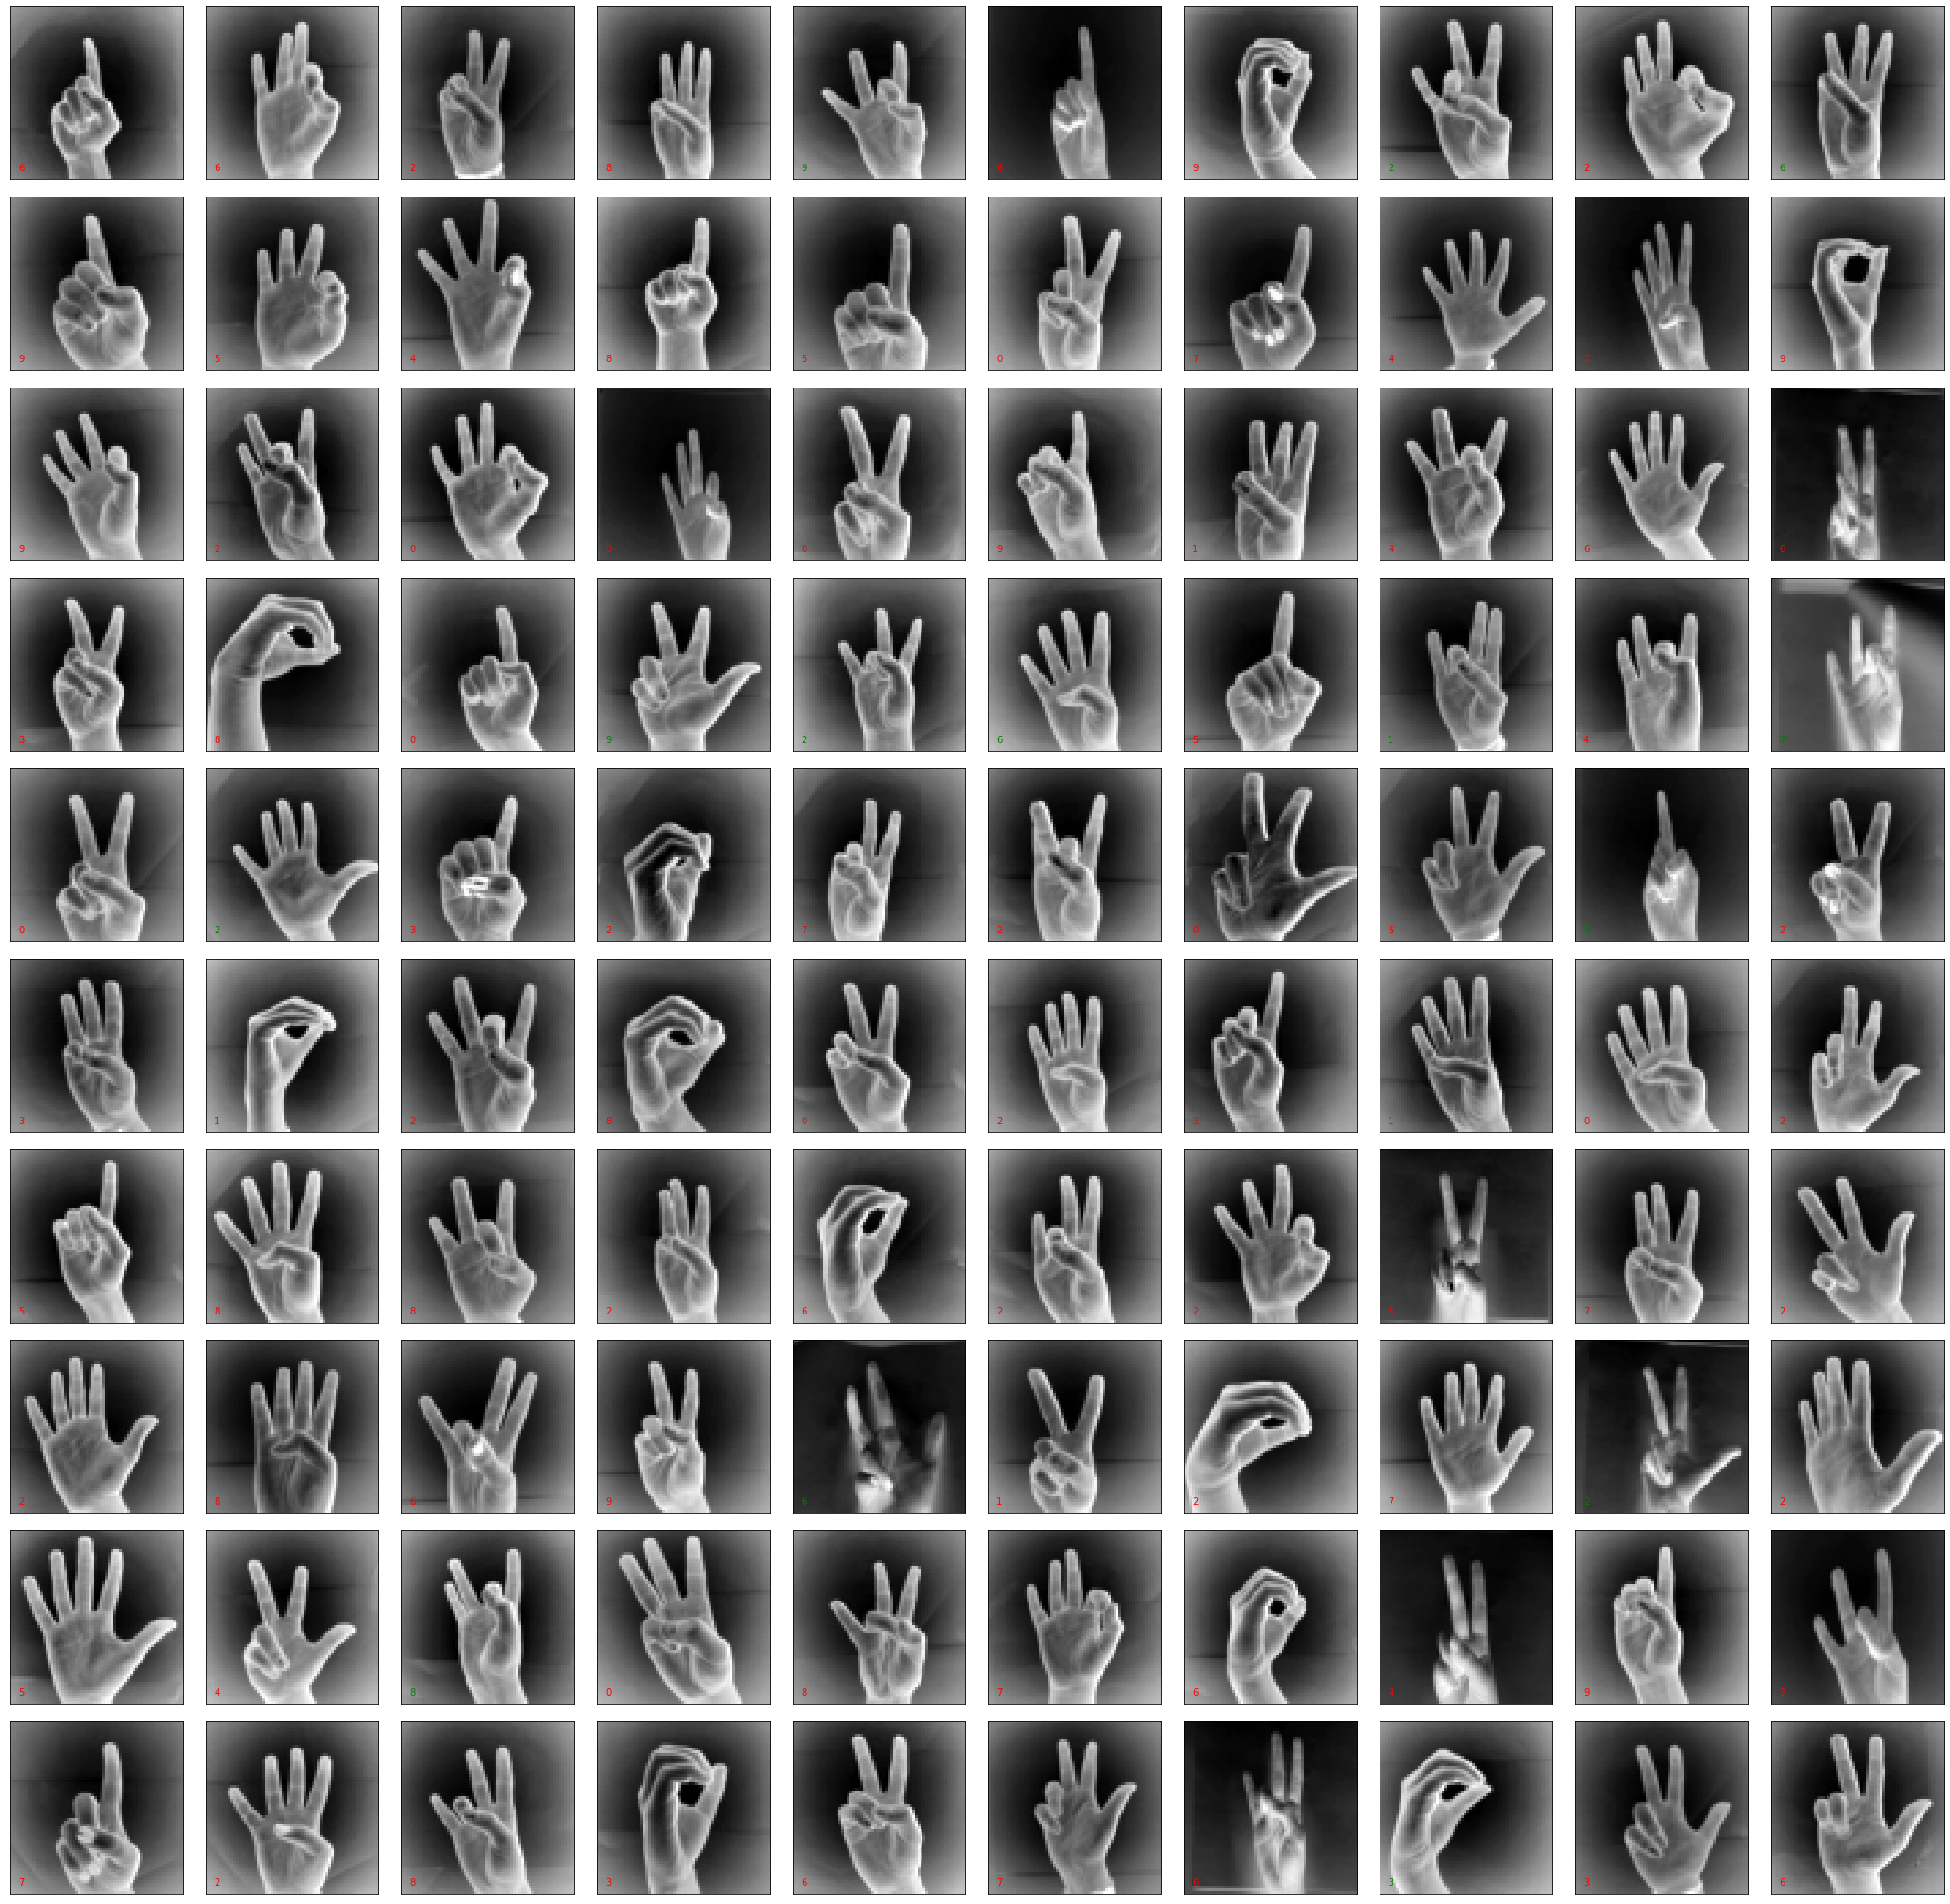

In [212]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Multinomial NB

In [213]:
thresh = np.arange(0.45, 0.61, 0.01)
thresh

array([0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 ])

In [214]:
for threshold in tqdm(thresh):
    
    scores = []
    
    Xbw = [clean_image(X[i], threshold = threshold) for i in range(len(X))]
    Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
    modelbw = MultinomialNB()
    modelbw.fit(Xbwtrain, Ytrain)
    
    scorebw = cross_val_score(modelbw, Xbw, Y, cv=20)
    
    scores.append(scorebw.mean())
    
    print(f'score : {scorebw.mean()}, threshold: {threshold}')

  6%|▋         | 1/16 [00:27<06:55, 27.73s/it]

score : 0.4437313293502614, threshold: 0.45


 12%|█▎        | 2/16 [00:55<06:28, 27.78s/it]

score : 0.4481002613890964, threshold: 0.46


 19%|█▉        | 3/16 [01:23<06:00, 27.76s/it]

score : 0.45440160567587756, threshold: 0.47000000000000003


 25%|██▌       | 4/16 [01:51<05:33, 27.78s/it]

score : 0.4631161314413742, threshold: 0.48000000000000004


 31%|███▏      | 5/16 [02:18<05:04, 27.69s/it]

score : 0.4742905153099327, threshold: 0.49000000000000005


 38%|███▊      | 6/16 [02:46<04:36, 27.63s/it]

score : 0.47768857356235994, threshold: 0.5


 44%|████▍     | 7/16 [03:13<04:08, 27.58s/it]

score : 0.48787808065720695, threshold: 0.51


 50%|█████     | 8/16 [03:41<03:41, 27.65s/it]

score : 0.4922470126960419, threshold: 0.52


 56%|█████▋    | 9/16 [04:08<03:13, 27.62s/it]

score : 0.4965972740851382, threshold: 0.53


 62%|██████▎   | 10/16 [04:36<02:45, 27.60s/it]

score : 0.49950522778192685, threshold: 0.54


 69%|██████▉   | 11/16 [05:06<02:21, 28.38s/it]

score : 0.5058019044062734, threshold: 0.55


 75%|███████▌  | 12/16 [05:34<01:53, 28.26s/it]

score : 0.5038694921583271, threshold: 0.56


 81%|████████▏ | 13/16 [06:03<01:25, 28.35s/it]

score : 0.5130927931292008, threshold: 0.5700000000000001


 88%|████████▊ | 14/16 [06:31<00:56, 28.48s/it]

score : 0.5126120238984317, threshold: 0.5800000000000001


 94%|█████████▍| 15/16 [06:59<00:28, 28.33s/it]

score : 0.5092233009708738, threshold: 0.5900000000000001


100%|██████████| 16/16 [07:27<00:00, 27.97s/it]

score : 0.50873786407767, threshold: 0.6000000000000001


In [215]:
Xbw = [clean_image(X[i], threshold = 0.57) for i in range(len(X))]

Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
modelbw = MultinomialNB()
modelbw.fit(Xbwtrain, Ytrain)

Ymodelbw = modelbw.predict(Xbwtest)

mat = confusion_matrix(Ytest, Ymodelbw)

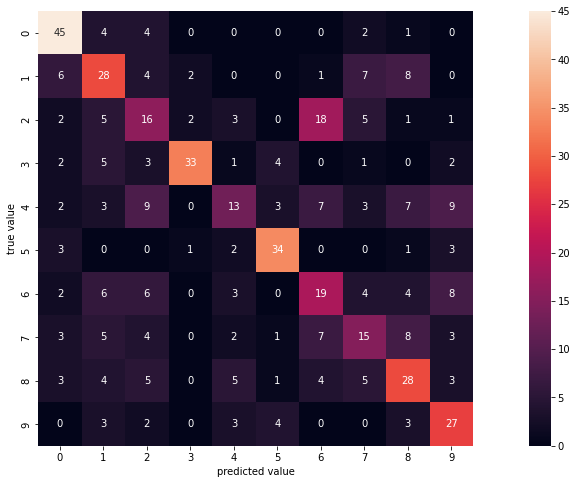

In [ ]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

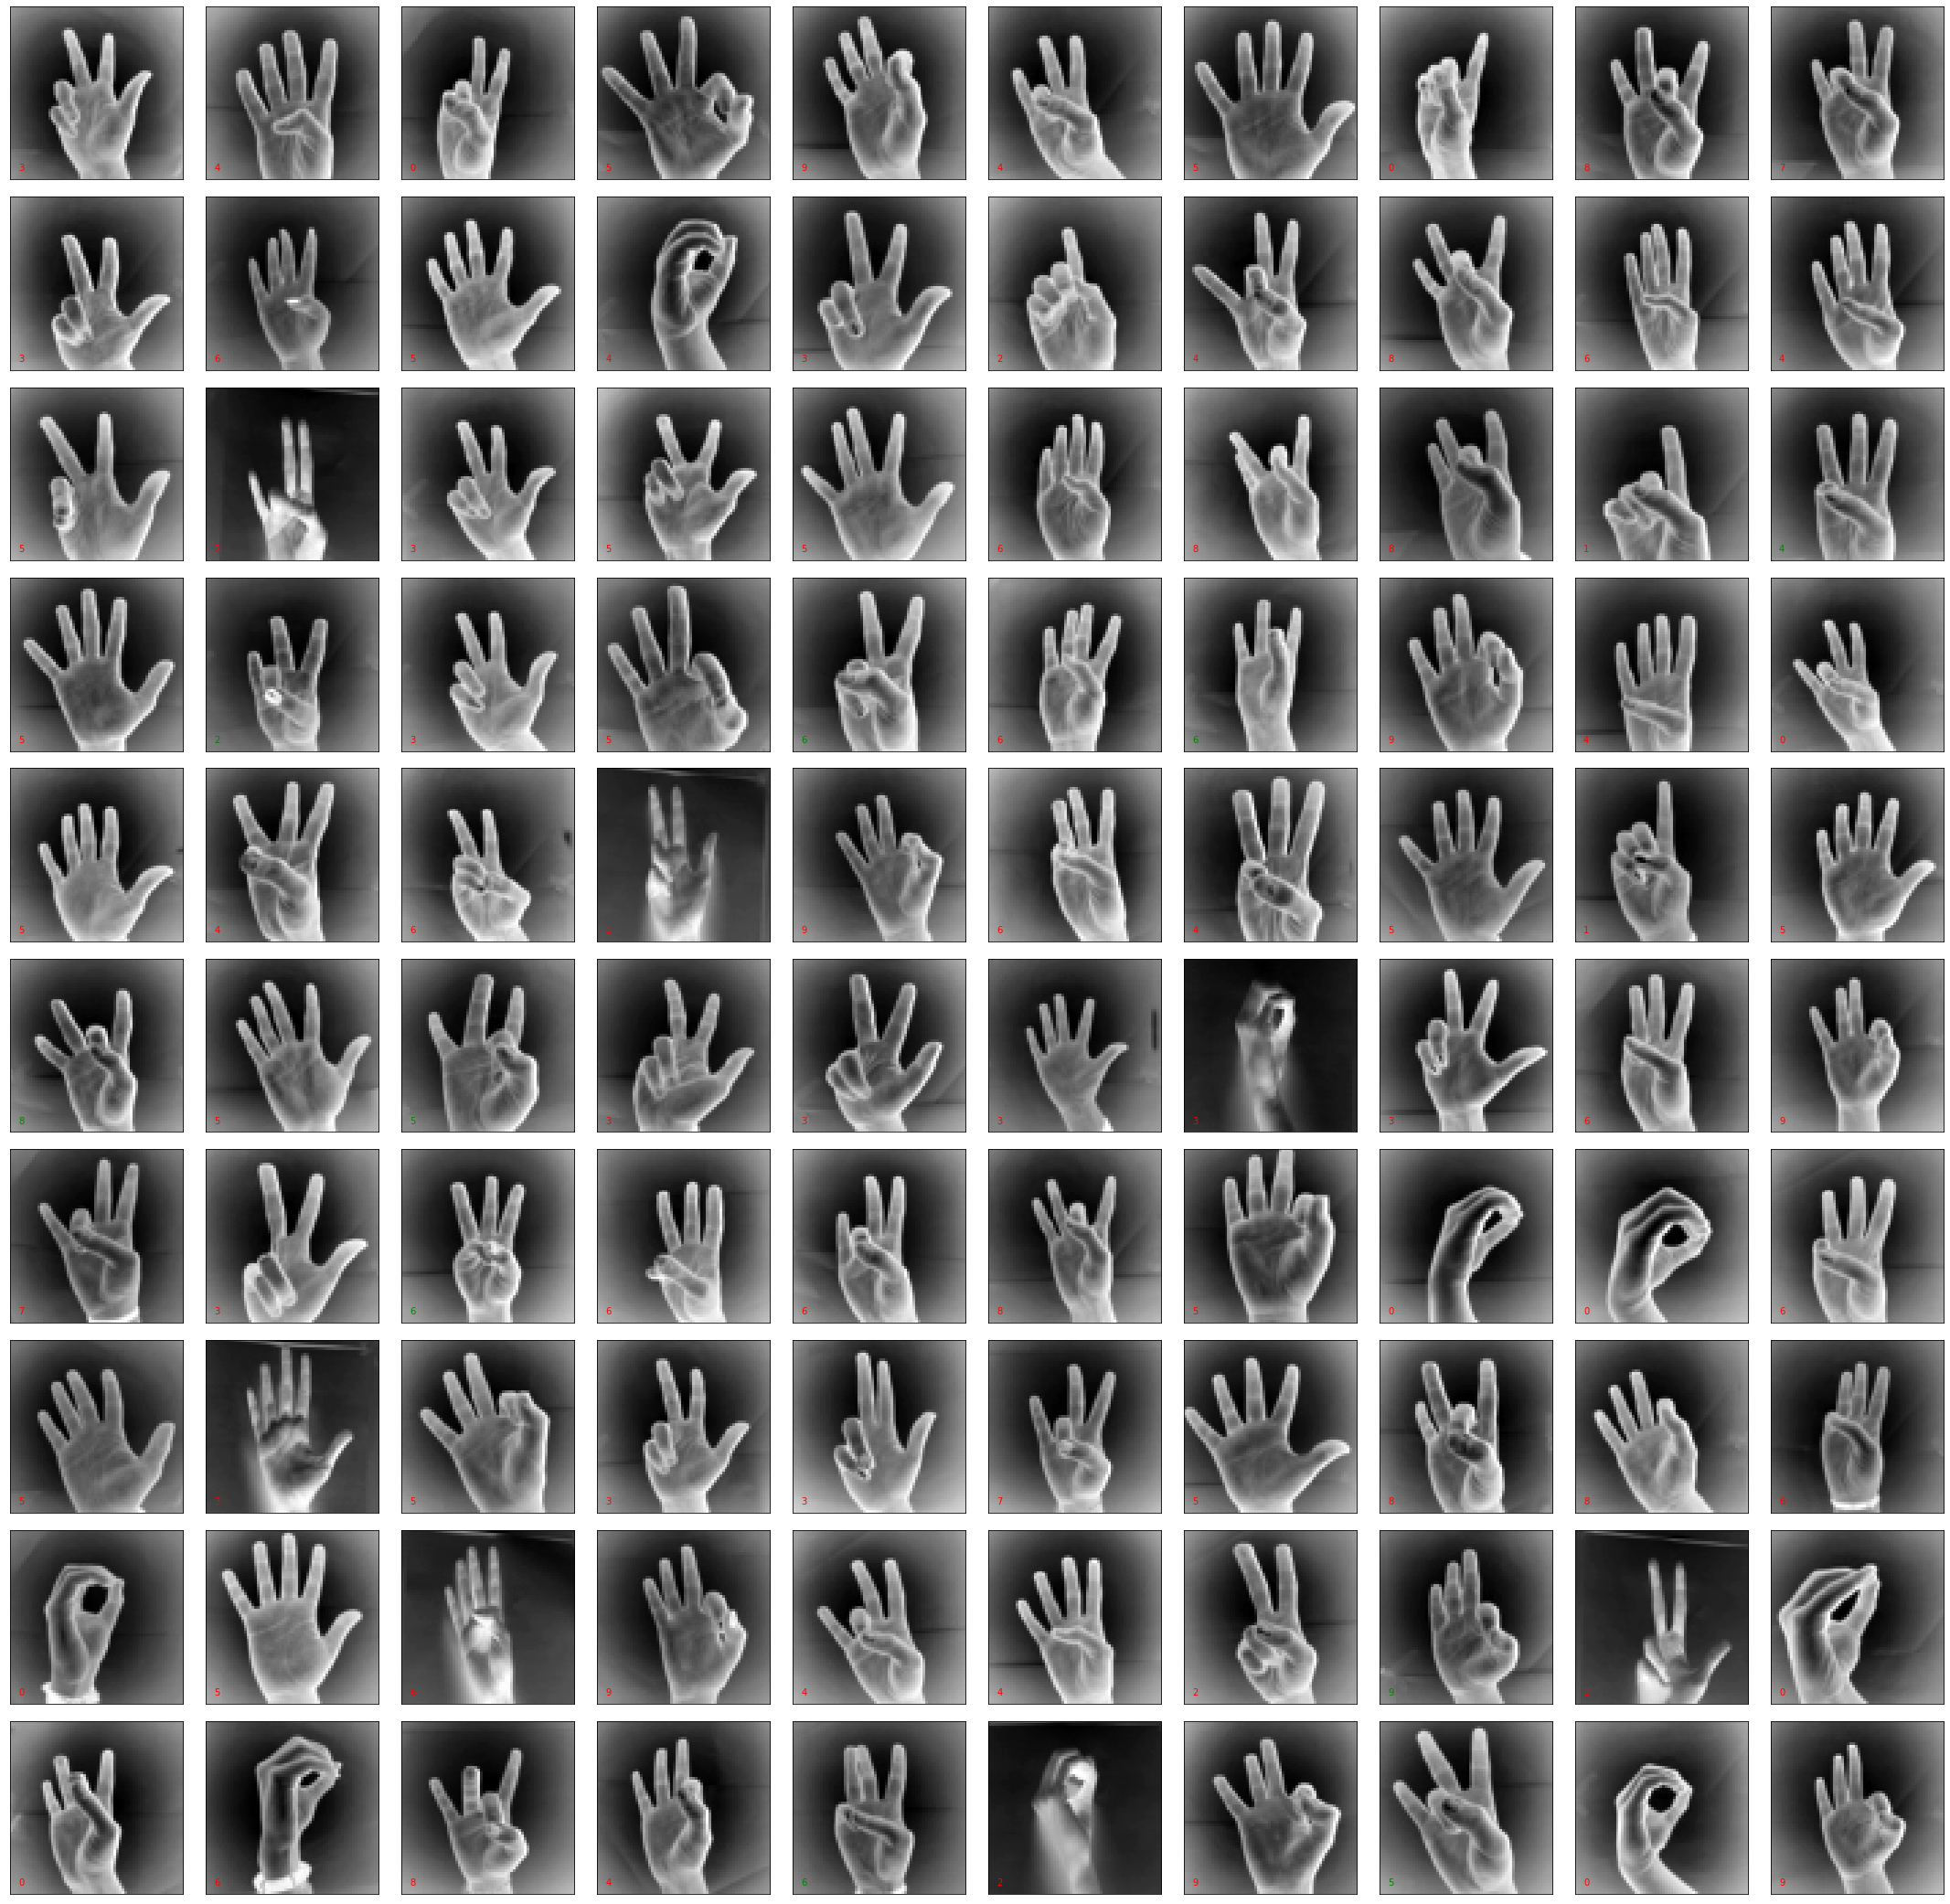

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Custom Gaussian for error understanding

In [ ]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [ ]:
img_indexes = np.where(Y == 6)[0]
for img_index in img_indexes :
    #plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
    likes = (model.custom_predict([X[img_index]]))
    top_l = model.classes_[likes[0].argmax()]
    if(top_l != 6):
        print(f"Top likelihood is: {top_l} for index {img_index}")

Top likelihood is: 2 for index 615
Top likelihood is: 8 for index 616
Top likelihood is: 2 for index 617
Top likelihood is: 4 for index 619
Top likelihood is: 2 for index 623
Top likelihood is: 0 for index 626
Top likelihood is: 7 for index 632
Top likelihood is: 2 for index 633
Top likelihood is: 2 for index 635
Top likelihood is: 0 for index 636
Top likelihood is: 4 for index 637
Top likelihood is: 0 for index 638
Top likelihood is: 2 for index 639
Top likelihood is: 0 for index 640
Top likelihood is: 7 for index 641
Top likelihood is: 2 for index 645
Top likelihood is: 0 for index 648
Top likelihood is: 7 for index 650
Top likelihood is: 2 for index 653
Top likelihood is: 2 for index 654
Top likelihood is: 2 for index 655
Top likelihood is: 2 for index 660
Top likelihood is: 9 for index 661
Top likelihood is: 4 for index 664
Top likelihood is: 0 for index 667
Top likelihood is: 2 for index 668
Top likelihood is: 1 for index 670
Top likelihood is: 0 for index 676
Top likelihood is: 2

Top likelihood is: 3 for index 813
Likelihood for class 0 : 2431.7856949387738
Likelihood for class 1 : -3084.7961703096375
Likelihood for class 2 : 1167.730139497847
Likelihood for class 3 : 3234.8730231760055
Likelihood for class 4 : 3083.5097357761347
Likelihood for class 5 : 2686.782396149008
Likelihood for class 6 : 3088.3443102074616
Likelihood for class 7 : 2182.5105516268814
Likelihood for class 8 : 2682.557167979319
Likelihood for class 9 : 2727.0063644622705


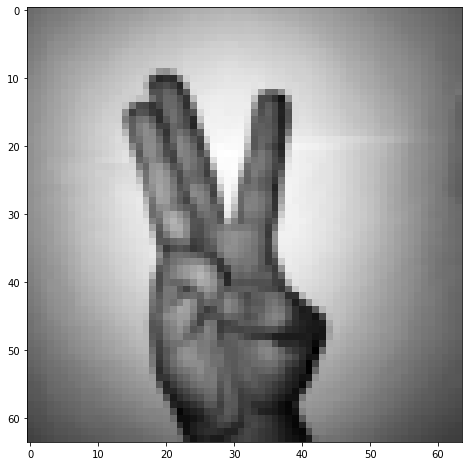

In [ ]:
# cose notate : 
# 636 c'é lo smalto  -- color filling
# 617 é inclinato    -- color filling
# 653 é inclinato
# 813 le dita sono attaccate -- edge recognition

img_index = 813
plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
likes = (model.custom_predict([X[img_index]]))
top_l = model.classes_[likes[0].argmax()]
if(top_l != 6):
    print(f"Top likelihood is: {top_l} for index {img_index}")
for i in range(len(model.classes_)) :
    class_l = likes[0][0][i]
    print(f"Likelihood for class {model.classes_[i]} : {class_l}")
